# LIME

In [2]:
import os
root_dir = '../../' if os.getcwd().split('/')[-1] != 'credit-now' else './'
os.chdir(root_dir)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from lime.lime_tabular import LimeTabularExplainer

import warnings
warnings.filterwarnings("ignore")

import credit_data
import font_family
font_family.set_font_family()

## Feature Importances

In [4]:
train_data, test_data, train_label, test_label = credit_data.load_data(encoding=False)
train_data.head()

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,age,employed_year,work_phone,phone,email,occyp_type,family_size,begin_year
419,1,1,0,0,360000.0,0,1,0,0,34.361644,11.936986,1,1,1,4,2,2.000000
1082,0,0,1,0,126000.0,2,0,0,3,45.180822,0.000000,0,0,0,0,2,0.916667
10725,0,1,0,1,351000.0,1,0,0,0,44.227397,23.230137,0,0,0,12,3,1.083333
20755,1,1,0,0,225000.0,1,0,0,0,41.432877,7.871233,0,1,0,3,2,1.583333
8348,0,1,1,1,112500.0,0,0,0,0,44.394521,2.534247,1,1,0,5,3,4.750000


In [5]:
columns = train_data.columns.tolist()
train_data = np.array(train_data)
test_data = np.array(test_data)
print(train_data.shape, test_data.shape, train_label.shape, test_label.shape)

(15906, 17) (6818, 17) (15906, 1) (6818, 1)


In [6]:
clf = XGBClassifier(seed = 0, n_estimators = 400, max_depth = 4, verbosity=0)
clf.fit(train_data, train_label)
accuracy_score(clf.predict(test_data), test_label)

0.7047521267233793

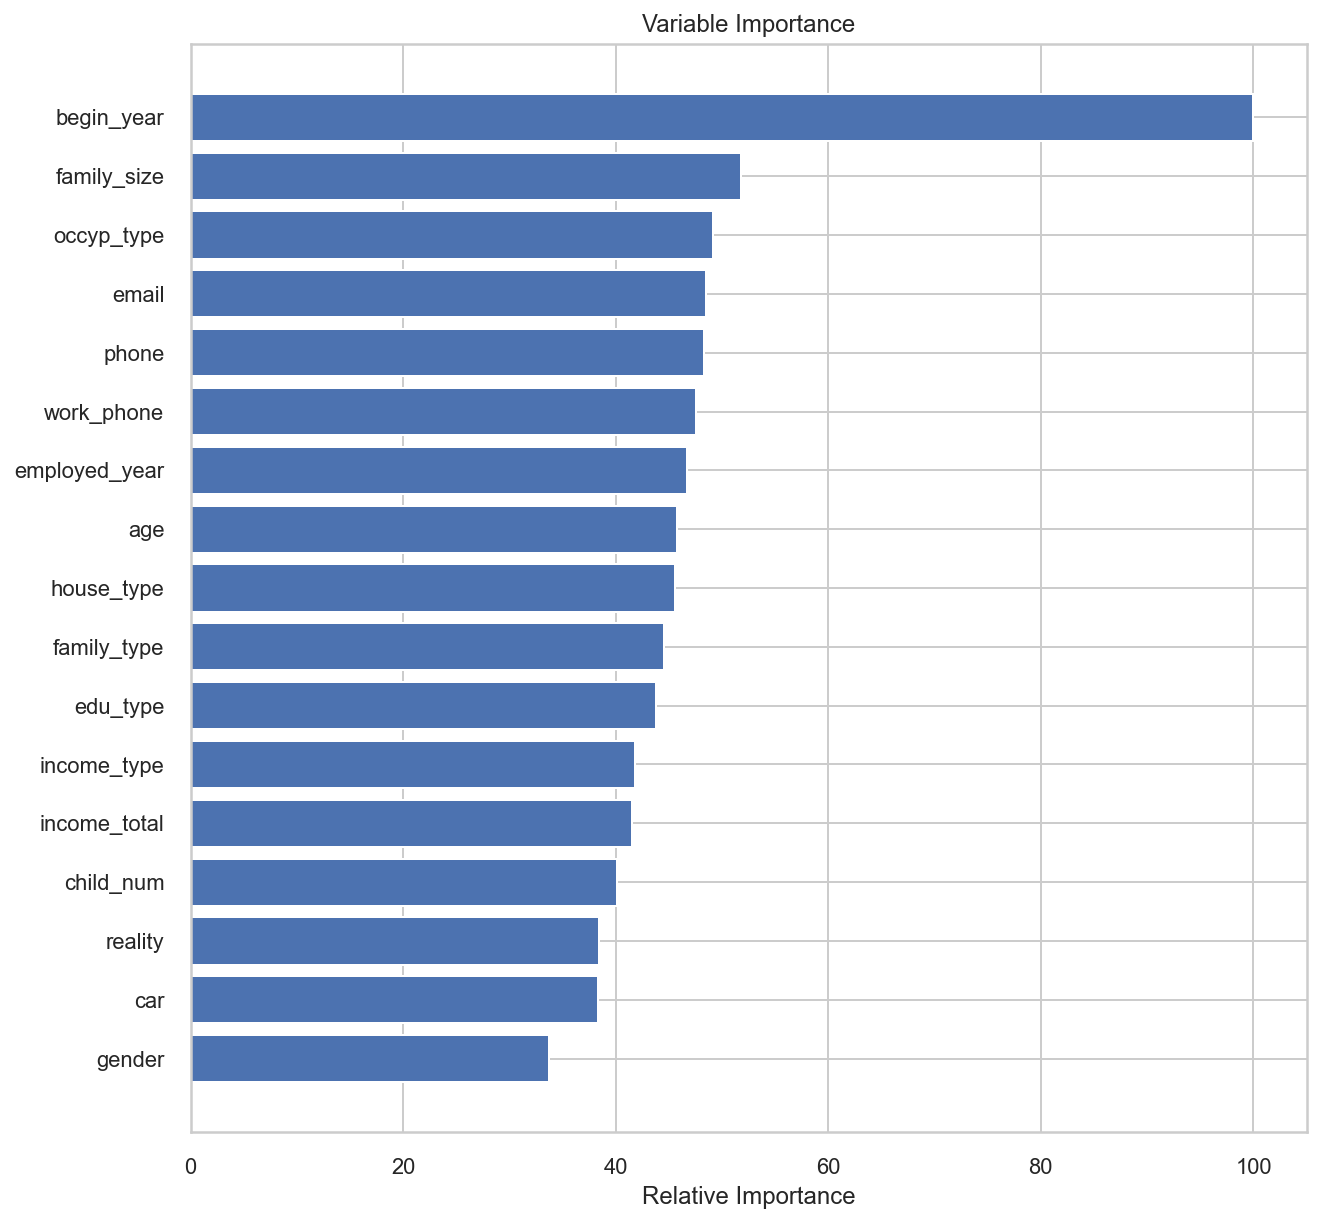

In [7]:
feature_importance = clf.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

sns.set(style="whitegrid", color_codes=True)
plt.figure(figsize = (10, 10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, columns)
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.savefig('graphs/feature_importances')
plt.show()

## LIME Explain

In [8]:
explainer = LimeTabularExplainer(train_data, mode='classification', class_names=[0,1,2],
                                training_labels=train_label, feature_names=columns)

i = 0
predict_fn = lambda x: clf.predict_proba(x.reshape(-1,17))
exp = explainer.explain_instance(test_data[i], predict_fn, labels=[0,1,2], num_features=17, num_samples=15906)

exp.save_to_file(f'graphs/lime/lime_explain_{i}.html')
exp.show_in_notebook(show_table=True, predict_proba=True, show_predicted_value=True)

## EDA Visualization

In [9]:
df, credit = credit_data.load_data(test_size=0, encoding=False)
df.head()

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,age,employed_year,work_phone,phone,email,occyp_type,family_size,begin_year,credit
0,1,1,0,1,1,247500.0,1,0,2,0,31.178082,4.219178,0,0,1,1,3,0.416667,1
1,2,0,1,1,0,450000.0,0,1,0,0,52.293151,12.147945,0,1,0,4,2,1.833333,2
2,3,1,0,1,0,202500.0,1,0,0,0,41.336986,5.731507,0,1,0,3,2,3.083333,0
3,4,1,1,1,0,157500.0,3,1,0,0,41.197260,5.767123,0,0,0,4,2,2.166667,2
4,5,1,0,1,2,270000.0,0,0,0,0,36.747945,13.687671,0,0,1,6,4,1.500000,1


In [10]:
total = [df['credit'].value_counts()[i] for i in range(3)]
total

[2791, 5413, 14520]

In [11]:
def subtract(total: list, cat: int, df: pd.DataFrame, range_in: bool) -> list:
    counts = df['credit'].value_counts()[cat]
    total[cat][range_in] = counts
    total[cat][2] -= counts

    return total

In [12]:
def draw_subplots(total: list, column: str, figsize=(8,5)):
    fig, ax = plt.subplots(1, 3, figsize=figsize)
    fig.suptitle(f'credit by {column}', y=0.8)

    for i in range(3):
        ax[i].pie(total[i],labels=['Not In','In','Others'],autopct='%.1f%%')
        ax[i].set(title=f'credit is {i}')

    return fig, ax

`begin_year`
- 발급 기간이 1년 이하면 신용 범주 **0에 속할 가능성**이 있음
- 발급 기간이 1년 이하면 신용 범주 **1에 속할 가능성**이 높음
- 발급 기간이 2년 초과 3.25년 이하면 신용 범주 **2에 속할 가능성**이 높음

`not begin_year`
- 발급 기간이 2년 초과 3.25년 이하면 신용 범주 **0에 속하지 않을 가능성**이 있음
- 발급 기간이 2년 초과 3.25년 이하면 신용 범주 **1에 속하지 않을 가능성**이 높음
- 발급 기간이 1년 이하면 신용 범주 **2에 속하지 않을 가능성**이 높음

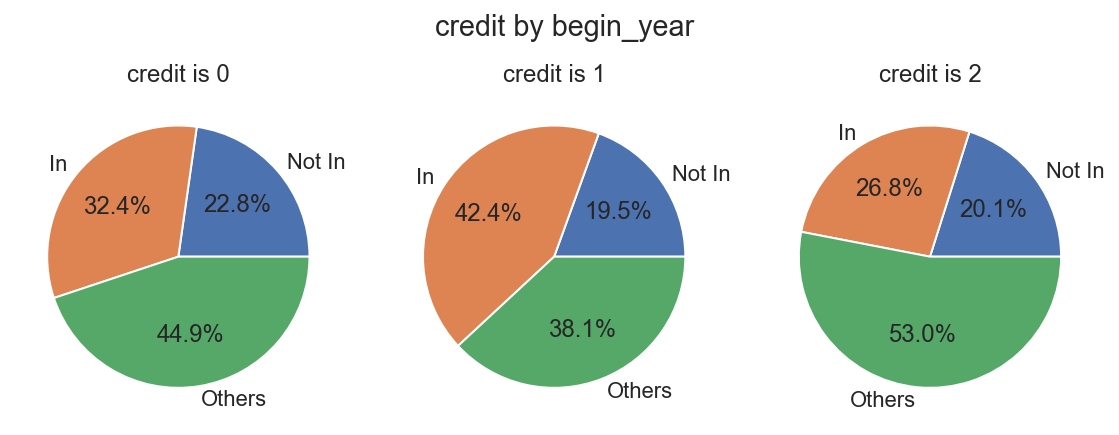

In [13]:
begin_total = [[0,0,total[i]] for i in range(3)]
column = 'begin_year'

begin_total = subtract(begin_total, 0, df[df[column] <= 1.0], True)
begin_total = subtract(begin_total, 0, df[(df[column] > 2.0) & (df[column] <= 3.25)], False)
begin_total = subtract(begin_total, 1, df[df[column] <= 1.0], True)
begin_total = subtract(begin_total, 1, df[(df[column] > 2.0) & (df[column] <= 3.25)], False)
begin_total = subtract(begin_total, 2, df[(df[column] > 2.0) & (df[column] <= 3.25)], True)
begin_total = subtract(begin_total, 2, df[df[column] <= 1.0], False)

sns.set(style="whitegrid", color_codes=True)
fig, ax = draw_subplots(begin_total, column)
plt.tight_layout()
plt.savefig(f'graphs/lime_eda/{column}')
plt.show()

`employed_year`
- 경력이 8.28년 초과일 경우 신용 범주 **0에 속할 가능성**이 있음
- 경력이 3.87년 초과 8.28년 이하일 경우 신용 범주 **1에 속할 가능성**이 있음
- 경력이 0.84년 이하일 경우 신용 범주 **2에 속할 가능성**이 높음

`not employed_year`
- 경력이 0.84년 이하일 경우 신용 범주 **0에 속하지 않을 가능성**이 있음
- 경력이 0.84년 이하일 경우 신용 범주 **1에 속하지 않을 가능성**이 있음
- 경력이 8.28년 초과일 경우 신용 범주 **2에 속하지 않을 가능성**이 있음

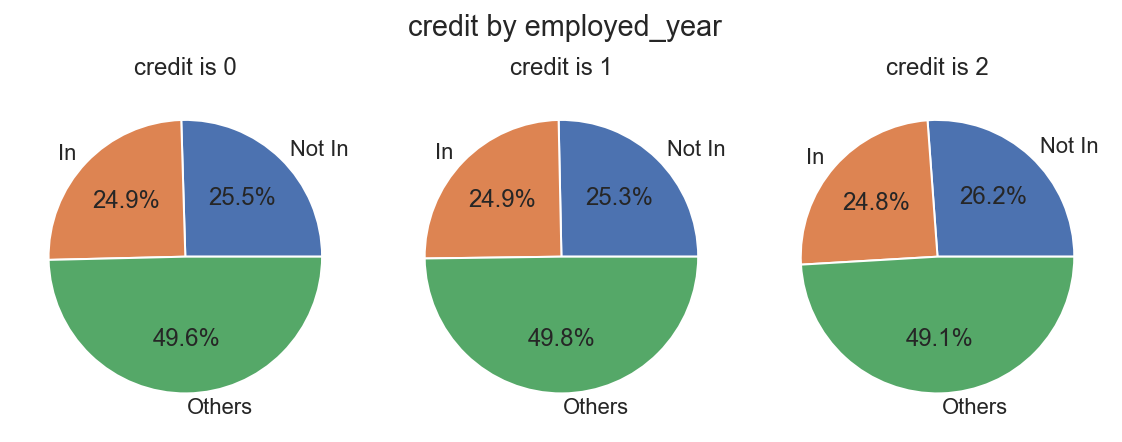

In [14]:
employed_total = [[0,0,total[i]] for i in range(3)]
column = 'employed_year'

employed_total = subtract(employed_total, 0, df[df[column] > 8.28], True)
employed_total = subtract(employed_total, 0, df[df[column] <= 0.84], False)
employed_total = subtract(employed_total, 1, df[(df[column] > 3.87) & (df[column] <= 8.28)], True)
employed_total = subtract(employed_total, 1, df[df[column] <= 0.84], False)
employed_total = subtract(employed_total, 2, df[df[column] <= 0.84], True)
employed_total = subtract(employed_total, 2, df[df[column] > 8.28], False)

sns.set(style="whitegrid", color_codes=True)
fig, ax = draw_subplots(employed_total, column)
plt.tight_layout()
plt.savefig(f'graphs/lime_eda/{column}')
plt.show()

`income_total`
- 수입이 121500 초과일 경우 신용 범주 **0에 속할 가능성**이 있음
- 수입이 121500 이하일 경우 신용 범주 **2에 속할 가능성**이 있음
- 대부분의 범위에서 신용 범주 **1에 속할 가능성**이 있음

`not income_total`
- 수입이 121500 이하일 경우 신용 범주 **0에 속하지 않을 가능성**이 있음
- 수입이 121500 초과 157500 이하일 경우 신용 범주 **1에 속하지 않을 가능성**이 있음
- 수입이 225000 초과일 경우 신용 범주 **2에 속하지 않을 가능성**이 있음

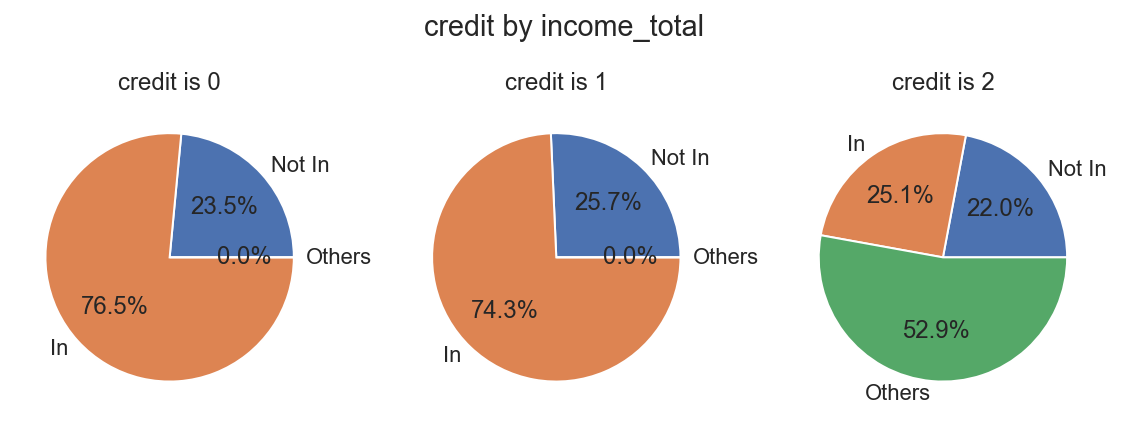

In [15]:
income_total = [[0,0,total[i]] for i in range(3)]
column = 'income_total'
income_total = subtract(income_total, 0, df[df[column] > 121500.0], True)
income_total = subtract(income_total, 0, df[df[column] <= 121500.0], False)
income_total = subtract(income_total, 1, df[~((df[column] > 121500.0) & (df[column] <= 157500.0))], True)
income_total = subtract(income_total, 1, df[(df[column] > 121500.0) & (df[column] <= 157500.0)], False)
income_total = subtract(income_total, 2, df[df[column] <= 121500.0], True)
income_total = subtract(income_total, 2, df[df[column] > 225000.0], False)

sns.set(style="whitegrid", color_codes=True)
fig, ax = draw_subplots(income_total, column)
plt.tight_layout()
plt.savefig(f'graphs/lime_eda/{column}')
plt.show()

`edu_type`
- 교육 수준이 'Secondary / secondary special'이면 신용 범주 **0에 속할 가능성**이 있음
- 교육 수준이 'Secondary / secondary special'이면 신용 범주 **1에 속할 가능성**이 있음
- 교육 수준이 'Higher education'이면 신용 범주 **2에 속할 가능성**이 있음

`not edu_type`
- 교육 수준이 'Higher education'이면 신용 범주 **0에 속하지 않을 가능성**이 있음
- 교육 수준이 'Higher education'이면 신용 범주 **1에 속하지 않을 가능성**이 있음
- 교육 수준이 'Secondary / secondary special'이면 신용 범주 **2에 속하지 않을 가능성**이 있음

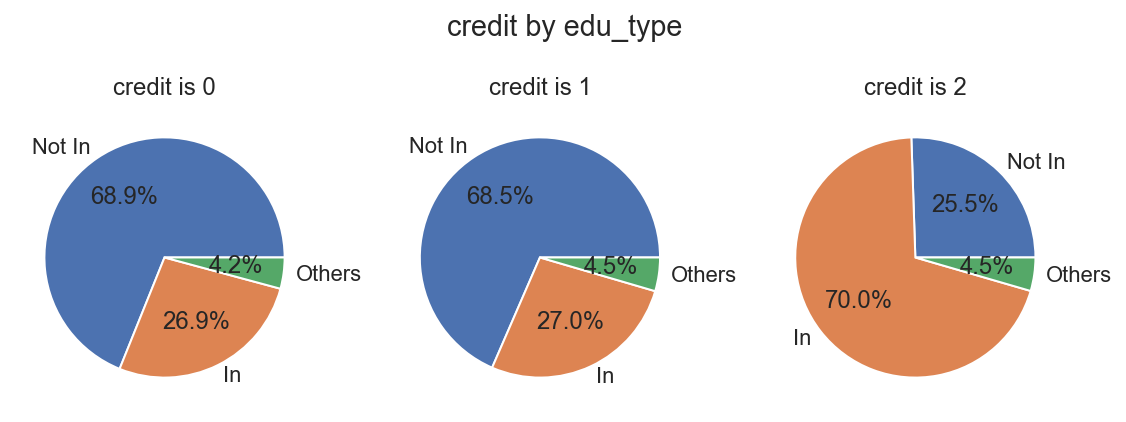

In [16]:
edu_total = [[0,0,total[i]] for i in range(3)]
column = 'edu_type'

edu_total = subtract(edu_total, 0, df[df[column] == 1], True)
edu_total = subtract(edu_total, 0, df[df[column] == 0], False)
edu_total = subtract(edu_total, 1, df[df[column] == 1], True)
edu_total = subtract(edu_total, 1, df[df[column] == 0], False)
edu_total = subtract(edu_total, 2, df[df[column] == 0], True)
edu_total = subtract(edu_total, 2, df[df[column] == 1], False)

sns.set(style="whitegrid", color_codes=True)
fig, ax = draw_subplots(edu_total, column)
plt.tight_layout()
plt.savefig(f'graphs/lime_eda/{column}')
plt.show()

`age`
- 나이가 34.4 이하일 경우 신용 범주 **0에 속할 가능성**이 있음
- 나이가 34.4 이하일 경우 신용 범주 **1에 속할 가능성**이 있음
- 나이가 43.32 초과일 경우 신용 범주 **2에 속할 가능성**이 있음

`not age`
- 나이가 43.23 초과일 경우 신용 범주 **0에 속하지 않을 가능성**이 있음
- 나이가 43.23 초과일 경우 신용 범주 **1에 속하지 않을 가능성**이 있음
- 나이가 34.4 이하일 경우 신용 범주 **2에 속하지 않을 가능성**이 높음

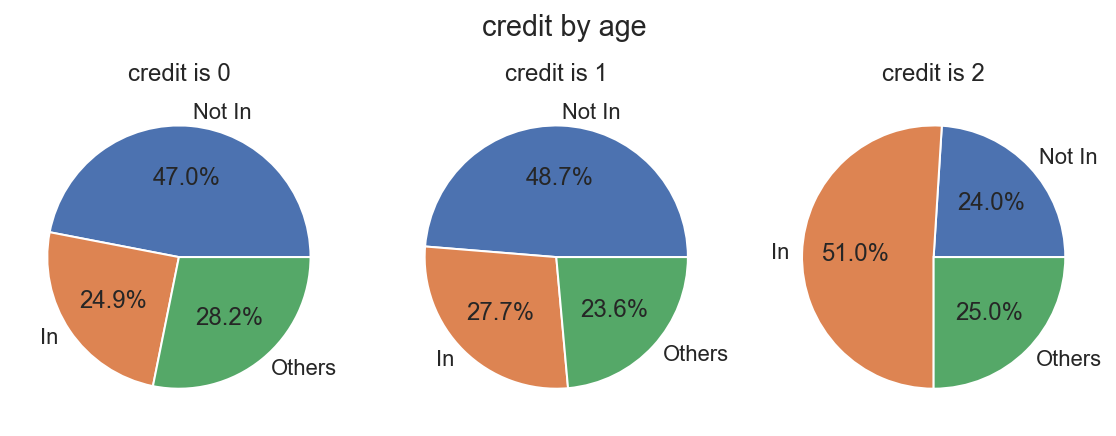

In [17]:
age_total = [[0,0,total[i]] for i in range(3)]
column = 'age'

age_total = subtract(age_total, 0, df[df[column] <= 34.4], True)
age_total = subtract(age_total, 0, df[df[column] > 43.23], False)
age_total = subtract(age_total, 1, df[df[column] <= 34.4], True)
age_total = subtract(age_total, 1, df[df[column] > 43.23], False)
age_total = subtract(age_total, 2, df[df[column] > 43.32], True)
age_total = subtract(age_total, 2, df[df[column] <= 34.4], False)

sns.set(style="whitegrid", color_codes=True)
fig, ax = draw_subplots(age_total, column)
plt.tight_layout()
plt.savefig(f'graphs/lime_eda/{column}')
plt.show()

`reality`
- 부동산이 없으면 신용 범주 **0에 속할 가능성**이 있음
- 부동산이 있으면 신용 범주 **1에 속할 가능성**이 있음
- 부동산이 없으면 신용 범주 **2에 속할 가능성**이 있음

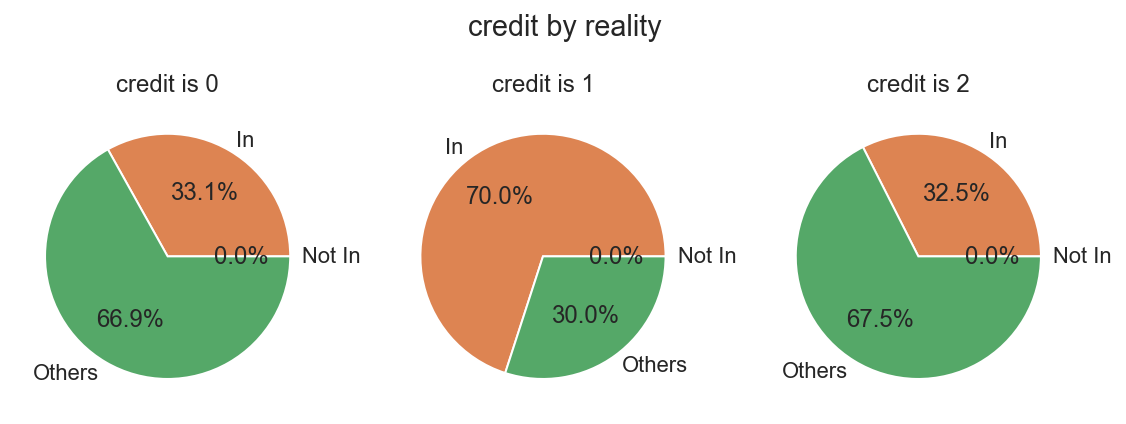

In [18]:
reality_total = [[0,0,total[i]] for i in range(3)]
column = 'reality'

reality_total = subtract(reality_total, 0, df[df[column] == 0], True)
reality_total = subtract(reality_total, 1, df[df[column] == 1], True)
reality_total = subtract(reality_total, 2, df[df[column] == 0], True)

sns.set(style="whitegrid", color_codes=True)
fig, ax = draw_subplots(reality_total, column)
plt.tight_layout()
plt.savefig(f'graphs/lime_eda/{column}')
plt.show()

`email`
- 이메일이 없으면 신용 범주 **0에 속할 가능성**이 있음
- 이메일이 없으면 신용 범주 **1에 속할 가능성**이 있음
- 이메일이 있으면 신용 범주 **2에 속할 가능성**이 높음

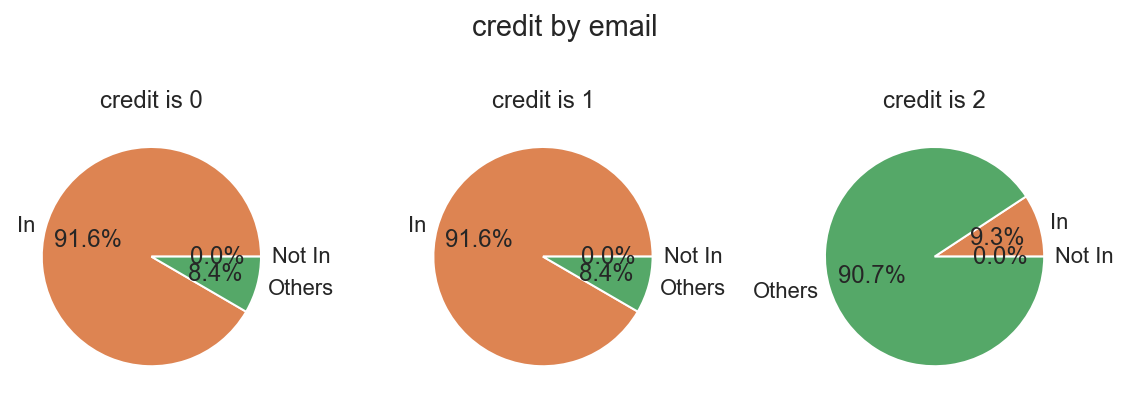

In [19]:
email_total = [[0,0,total[i]] for i in range(3)]
column = 'email'

email_total = subtract(email_total, 0, df[df[column] == 0], True)
email_total = subtract(email_total, 1, df[df[column] == 0], True)
email_total = subtract(email_total, 2, df[df[column] == 1], True)

sns.set(style="whitegrid", color_codes=True)
fig, ax = draw_subplots(email_total, column)
plt.tight_layout()
plt.savefig(f'graphs/lime_eda/{column}')
plt.show()

`gender`
- 성별이 여성이면 신용 범주 **0에 속할 가능성**이 있음
- 성별이 여성이면 신용 범주 **1에 속할 가능성**이 있음

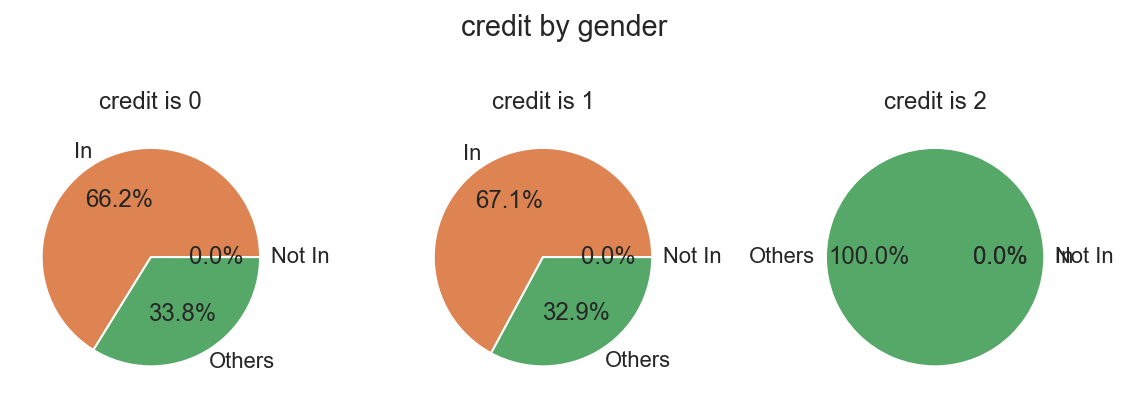

In [20]:
gender_total = [[0,0,total[i]] for i in range(3)]
column = 'gender'

gender_total = subtract(gender_total, 0, df[df[column] == 1], True)
gender_total = subtract(gender_total, 1, df[df[column] == 1], True)

sns.set(style="whitegrid", color_codes=True)
fig, ax = draw_subplots(gender_total, column)
plt.tight_layout()
plt.savefig(f'graphs/lime_eda/{column}')
plt.show()

`car`
- 차량이 없으면 신용 범주 **0에 속할 가능성**이 있음
- 차량이 없으면 신용 범주 **1에 속할 가능성**이 있음

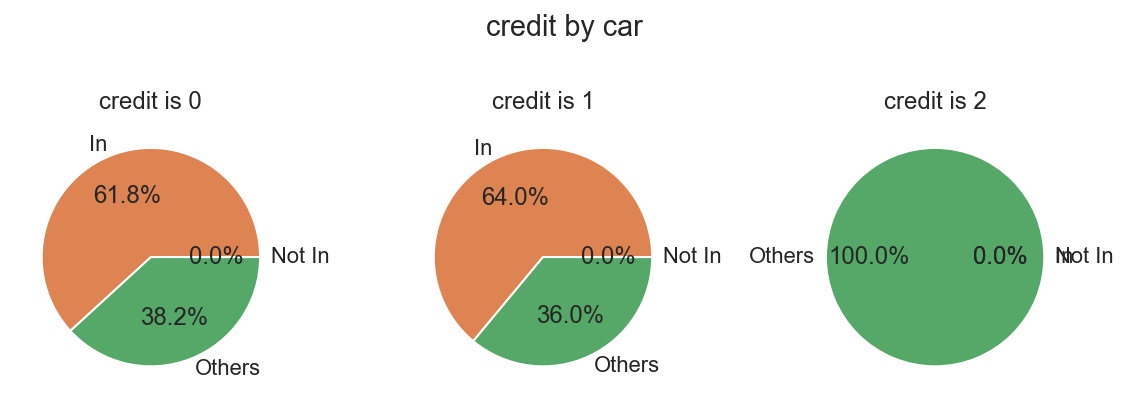

In [21]:
car_total = [[0,0,total[i]] for i in range(3)]
column = 'car'

car_total = subtract(car_total, 0, df[df[column] == 0], True)
car_total = subtract(car_total, 1, df[df[column] == 0], True)

sns.set(style="whitegrid", color_codes=True)
fig, ax = draw_subplots(car_total, column)
plt.tight_layout()
plt.savefig(f'graphs/lime_eda/{column}')
plt.show()

`child_num`
- 자식이 없으면 신용 범주 **0에 속할 가능성**이 있음
- 자식이 있으면 신용 범주 **2에 속할 가능성**이 있음

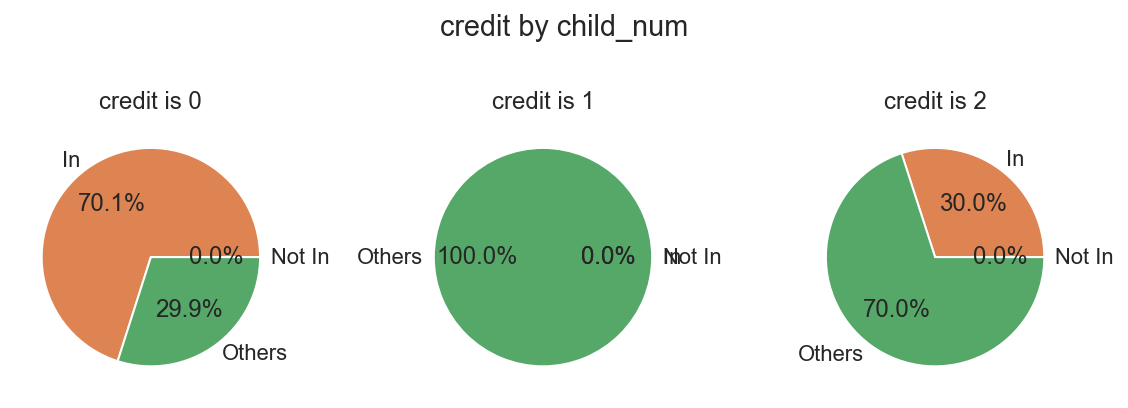

In [22]:
child_total = [[0,0,total[i]] for i in range(3)]
column = 'child_num'

child_total = subtract(child_total, 0, df[df[column] == 0], True)
child_total = subtract(child_total, 2, df[df[column] > 0], True)

sns.set(style="whitegrid", color_codes=True)
fig, ax = draw_subplots(child_total, column)
plt.tight_layout()
plt.savefig(f'graphs/lime_eda/{column}')
plt.show()

`income_type`
- 소득이 'Commercial associate'이면 신용 범주 **1에 속할 가능성**이 있음
- 소득이 'Penisoner', 'State servant', 'Student'이면 신용 범주 **2에 속할 가능성**이 있음

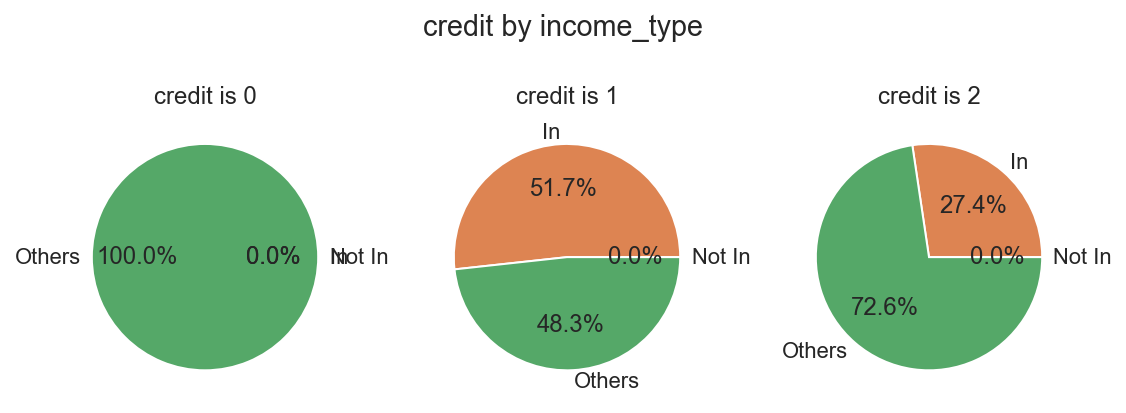

In [23]:
income_type_total = [[0,0,total[i]] for i in range(3)]
column = 'income_type'

income_type_total = subtract(income_type_total, 1, df[df[column] == 0], True)
income_type_total = subtract(income_type_total, 2, df[df[column] >= 2], True)

sns.set(style="whitegrid", color_codes=True)
fig, ax = draw_subplots(income_type_total, column)
plt.tight_layout()
plt.savefig(f'graphs/lime_eda/{column}')
plt.show()